In [104]:
from google.colab import drive

drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

In [106]:
from tensorflow.keras import layers, models

def build_generator(latent_dim):
    model = models.Sequential()

    # Dense layer to map noise to an intermediate image representation
    model.add(layers.Dense(128 * 8 * 8, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((8, 8, 128)))

    # Upsampling layers to increase the spatial dimensions
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Output layer with tanh activation to ensure pixel values are in the range [-1, 1]
    model.add(layers.Conv2D(3, (3, 3), activation='tanh', padding='same'))

    return model

# Example usage:
latent_dim = 100  # Adjust as needed
generator = build_generator(latent_dim)
generator.summary()


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 8192)              827392    
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_12 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 16, 16, 128)       262272    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_13 (Conv2  (None, 32, 32, 128)       262272    
 DTranspose)                                         

In [107]:
def build_discriminator(input_shape):
    model = models.Sequential()

    # Convolutional layers to extract features from the input image
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Flatten the feature maps and feed them into a dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Example usage:
input_shape = (64, 64, 3)  # Adjust based on your image dimensions
discriminator = build_discriminator(input_shape)
discriminator.summary()



Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 flatten_12 (Flatten)        (None, 16384)           

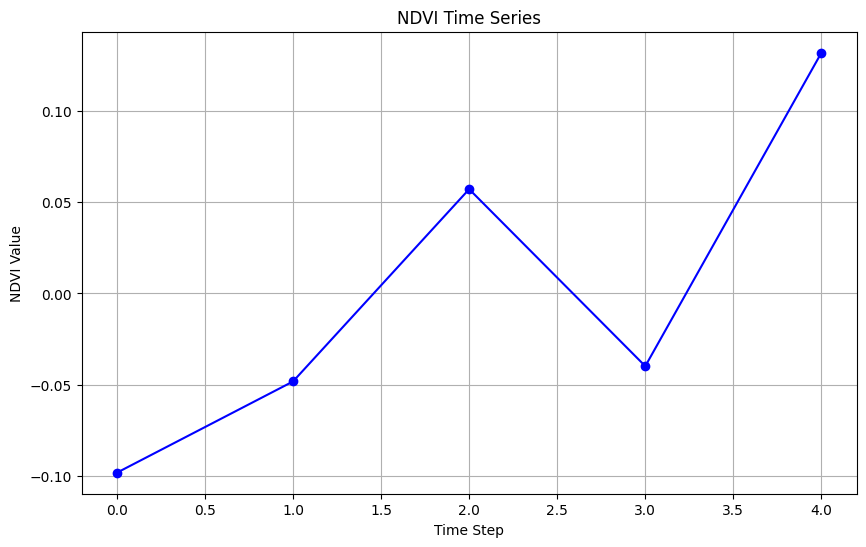

In [108]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_ndvi(red_band, nir_band):
    """
    Calculate NDVI from red and near-infrared bands.
    NDVI = (NIR - Red) / (NIR + Red)
    """
    ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-10)
    return ndvi

def calculate_ndvi_time_series(image_folder):
    """
    Calculate NDVI for a time series of images and plot the results.
    """
    # List all image files in the input folder
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')])

    # Initialize lists to store NDVI values and time steps
    ndvi_values = []
    time_steps = []

    # Loop through the time series
    for i in range(len(image_files) - 1):
        # Load the red and near-infrared bands for consecutive images
        red_band_prev = cv2.imread(os.path.join(image_folder, image_files[i]), cv2.IMREAD_GRAYSCALE).astype(float)
        nir_band_prev = cv2.imread(os.path.join(image_folder, image_files[i + 1]), cv2.IMREAD_GRAYSCALE).astype(float)

        # Calculate NDVI
        ndvi_result = np.mean(calculate_ndvi(red_band_prev, nir_band_prev))

        # Append NDVI value and time step
        ndvi_values.append(ndvi_result)
        time_steps.append(i)

    # Plot the NDVI time series
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, ndvi_values, marker='o', linestyle='-', color='b')
    plt.title('NDVI Time Series')
    plt.xlabel('Time Step')
    plt.ylabel('NDVI Value')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Specify the input folder containing time series images in your Google Drive
    input_folder_drive = '/content/drive/MyDrive/archive (1)/set1'

    # Calculate NDVI for the time series and plot the results
    calculate_ndvi_time_series(input_folder_drive)


In [109]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Define constants
latent_dim = 100  # Dimensionality of the random noise
ndvi_shape = (num_time_steps, )  # Shape of the NDVI time series

# Generator model
def build_generator(latent_dim, ndvi_shape):
    model = Sequential()

    # Input layer
    model.add(Dense(128, input_dim=latent_dim, activation='relu'))

    # Hidden layers
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))

    # Output layer
    model.add(Dense(np.prod(ndvi_shape), activation='tanh'))
    model.add(Reshape(ndvi_shape))

    return model

# Discriminator model
def build_discriminator(ndvi_shape):
    model = Sequential()

    # Input layer
    model.add(Flatten(input_shape=ndvi_shape))

    # Hidden layers
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    return model

# Combine generator and discriminator into a GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()

    # Generator
    model.add(generator)

    # Discriminator
    model.add(discriminator)

    return model

# Build and compile the models
generator = build_generator(latent_dim, ndvi_shape)
discriminator = build_discriminator(ndvi_shape)

generator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['accuracy'])

# Build and compile the GAN model
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002))


1/1 [==============================] - 0s 81ms/step


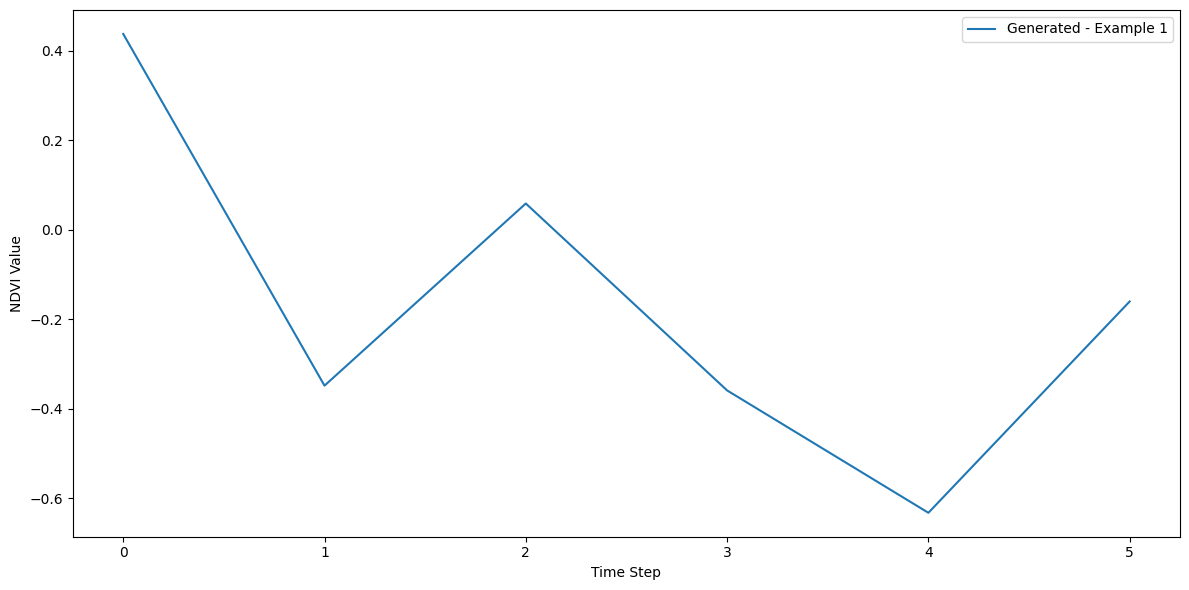

1/1 [==============================] - 0s 20ms/step


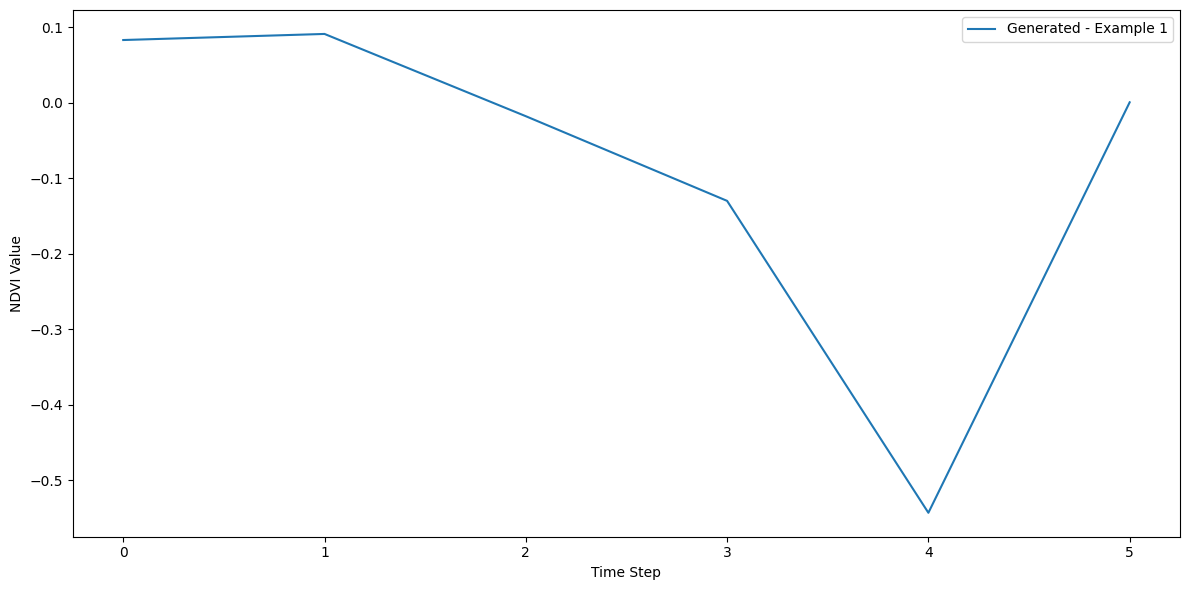

1/1 [==============================] - 0s 20ms/step


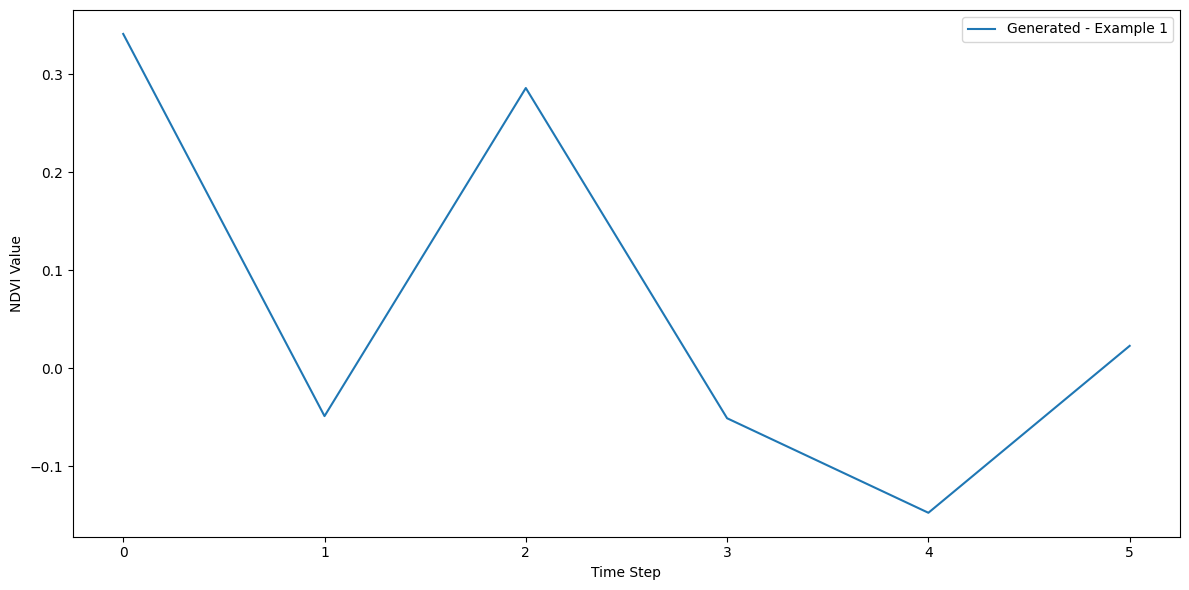

1/1 [==============================] - 0s 20ms/step


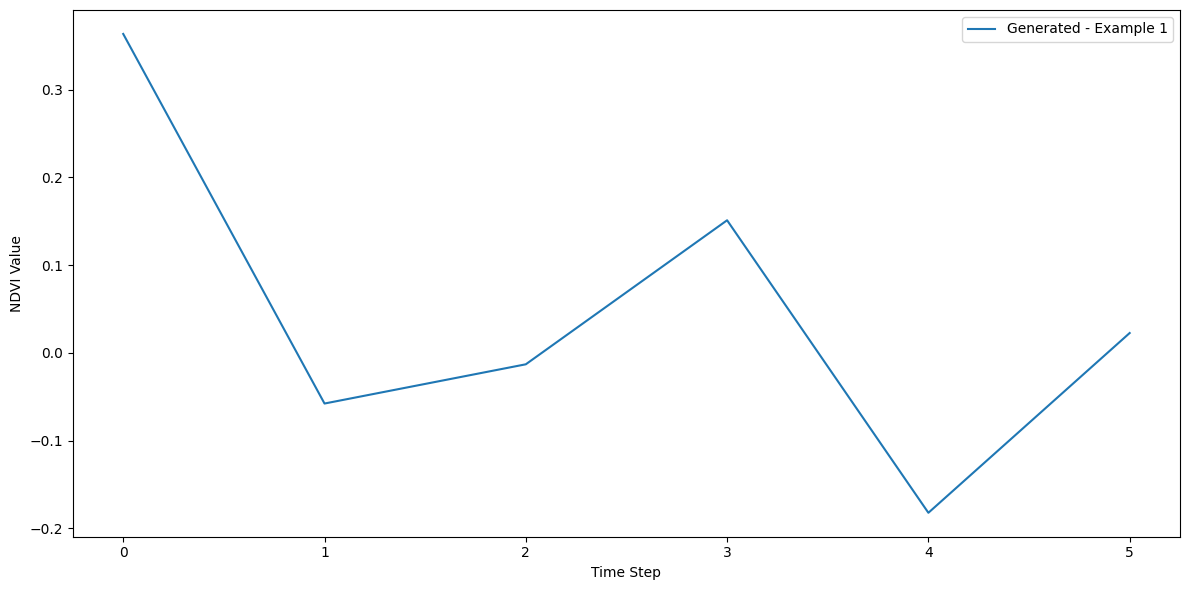

1/1 [==============================] - 0s 19ms/step


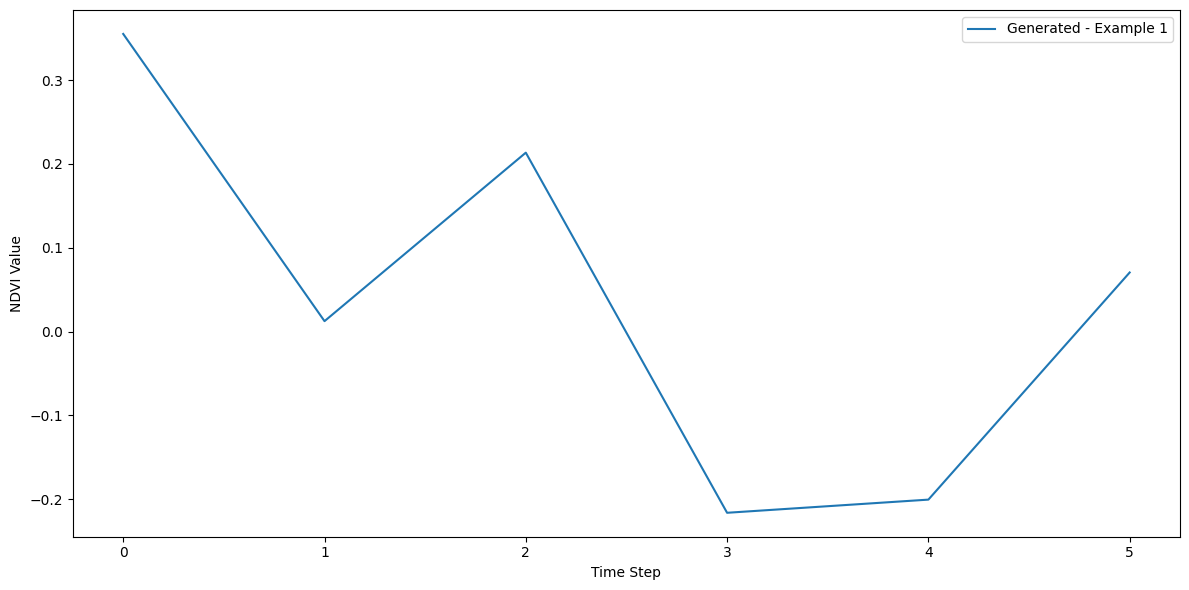

In [110]:
import matplotlib.pyplot as plt

def save_and_visualize_generated_images(epoch, generator, examples=1):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    generated_ndvi = generator.predict(noise)

    # Visualize the generated NDVI time series
    plt.figure(figsize=(12, 6))
    for i in range(examples):
        plt.subplot(examples, 1, i + 1)
        plt.plot(generated_ndvi[i], label=f'Generated - Example {i + 1}')
        plt.xlabel('Time Step')
        plt.ylabel('NDVI Value')
        plt.legend()
    plt.tight_layout()
    plt.savefig(f'generated_ndvi_epoch_{epoch}.png')
    plt.show()

def train_gan(generator, discriminator, gan, epochs, batch_size):

    for epoch in range(epochs):
        if epoch % save_interval == 0:
            save_and_visualize_generated_images(epoch, generator)

# Set hyperparameters
epochs = 5000
batch_size = 32
save_interval = 1000  # Interval to save and visualize generated images


train_gan(generator, discriminator, gan, epochs, batch_size)


1/1 [==============================] - 0s 20ms/step


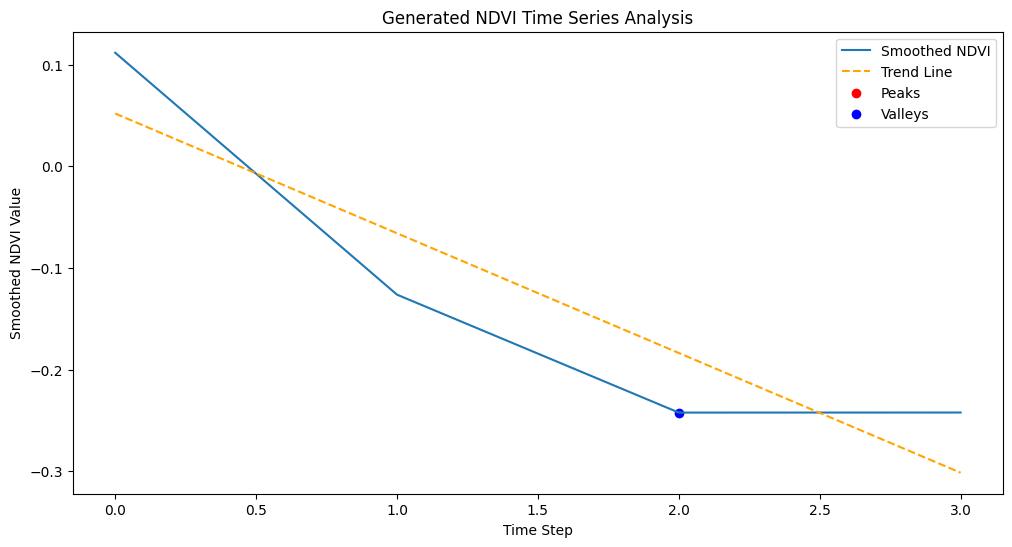

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Function to analyze generated NDVI time series
def analyze_ndvi_time_series(generated_ndvi):
    # Smoothing the time series
    smoothed_ndvi = np.convolve(generated_ndvi, np.ones(3)/3, mode='valid')

    # Trend identification using linear regression
    trend = np.polyfit(np.arange(len(smoothed_ndvi)), smoothed_ndvi, 1)
    trend_line = np.polyval(trend, np.arange(len(smoothed_ndvi)))

    # Peak and valley detection
    peaks, _ = find_peaks(smoothed_ndvi, height=0.0)
    valleys, _ = find_peaks(-smoothed_ndvi, height=0.0)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(smoothed_ndvi, label='Smoothed NDVI')
    plt.plot(trend_line, label='Trend Line', linestyle='--', color='orange')
    plt.scatter(peaks, smoothed_ndvi[peaks], marker='o', color='red', label='Peaks')
    plt.scatter(valleys, smoothed_ndvi[valleys], marker='o', color='blue', label='Valleys')
    plt.xlabel('Time Step')
    plt.ylabel('Smoothed NDVI Value')
    plt.legend()
    plt.title('Generated NDVI Time Series Analysis')
    plt.show()

# Example usage after generating the NDVI time series
num_examples = 1  # Number of examples generated
generated_ndvi_example = generator.predict(np.random.normal(0, 1, (num_examples, latent_dim)))
generated_ndvi_example = np.squeeze(generated_ndvi_example)

# Analyze the generated NDVI time series
analyze_ndvi_time_series(generated_ndvi_example)


In [112]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from skimage.measure import shannon_entropy

# Function to extract features from NDVI time series images
def extract_features(ndvi_images):
    features = []
    for image in ndvi_images:
        # Example features: mean, variance, Shannon entropy
        mean_value = np.mean(image)
        variance_value = np.var(image)
        entropy_value = shannon_entropy(image.flatten())

        features.append([mean_value, variance_value, entropy_value])

    return np.array(features)

num_samples = 1000
num_timesteps = 10
latent_dim = 100

# Generate synthetic data for illustration purposes
X_generated = np.random.normal(0, 1, (num_samples, num_timesteps, latent_dim))
y_generated = np.random.choice(['Steady Growth', 'Fluctuating Growth'], size=num_samples)

# Extract features from the generated NDVI data
X_generated_features = extract_features(X_generated)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_generated_features, y_generated, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Assuming you have new generated NDVI data for prediction (replace this with your actual data)
new_generated_ndvi_for_prediction = np.random.normal(0, 1, (5, num_timesteps, latent_dim))

# Extract features from the new generated NDVI data
new_generated_ndvi_features = extract_features(new_generated_ndvi_for_prediction)

# Predict growth patterns for the new data
predicted_growth_patterns = rf_classifier.predict(new_generated_ndvi_features)

# Display the predicted growth patterns
print("Predicted Growth Patterns for New Data:", predicted_growth_patterns)


Accuracy: 0.515
Classification Report:
                     precision    recall  f1-score   support

Fluctuating Growth       0.55      0.54      0.54       108
     Steady Growth       0.47      0.49      0.48        92

          accuracy                           0.52       200
         macro avg       0.51      0.51      0.51       200
      weighted avg       0.52      0.52      0.52       200

Predicted Growth Patterns for New Data: ['Fluctuating Growth' 'Fluctuating Growth' 'Fluctuating Growth'
 'Steady Growth' 'Steady Growth']
